# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [577]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image


### Hyperparameters

In [578]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [579]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [580]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


In [528]:
class_counts = {class_names[i]: 0 for i in range(len(class_names))}

for data in train_set:
    _, label = data
    class_name = class_names[label]
    class_counts[class_name] += 1

print(class_counts)


{'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}


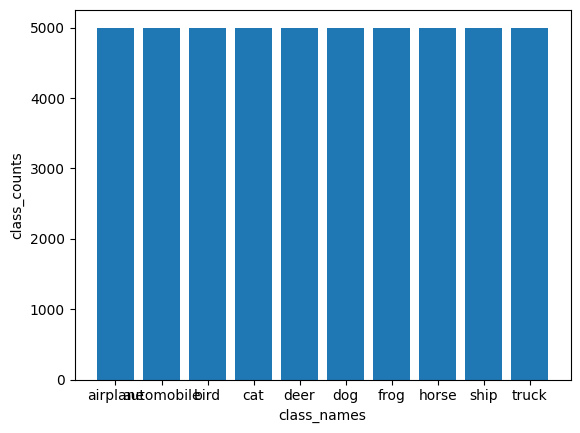

In [458]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
class_counts = [5000,5000,5000,5000,5000,5000,5000,5000,5000,5000]
plt.bar(class_names, class_counts)
plt.xlabel('class_names')
plt.ylabel('class_counts')
plt.show()

### Model

In [581]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [582]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [583]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [519]:
##################### Write your answer here ##################
# Define the loss function
criterion = nn.L1Loss()
###############################################################

In [520]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    target = target.unsqueeze(1)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

In [521]:
def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    target = target.unsqueeze(1)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

### Model Training

In [522]:
from sklearn.metrics import f1_score, recall_score

training_loss = []
training_acc = []
training_f1 = []
training_recall = []

testing_loss = []
testing_acc = []
testing_f1 = []
testing_recall = []

k = 3
top_k_accuracies = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0
    
    epoch_true1 = []
    epoch_pred1 = []
    
    epoch_true2 = []
    epoch_pred2 = []
    
    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
       # print(outputs.size(),target.size())
        _, preds = torch.max(outputs, 1)

        #epoch_pred.append(preds.cpu())
        #print(preds.cpu().numpy())
        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)
        
        epoch_true1.extend(target.data.cpu().numpy())
        epoch_pred1.extend(preds.cpu().numpy())

        #epoch_true.append(target.data.cpu())
        #print(target.data.cpu().numpy())
        #print(f1_score(preds.cpu().numpy(), target.data.cpu().numpy(), average='weighted'))
        #F1_score.append(f1_score(preds.cpu().numpy(), target.data.cpu().numpy(),average='macro'))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    train_f1 = f1_score(epoch_true1, epoch_pred1, average="macro")
    train_recall = recall_score(epoch_true1, epoch_pred1, average="macro")
    
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    #print(f1)
    #print(recall)

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    training_f1.append(train_f1)
    training_recall.append(train_recall)
    

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            epoch_true2.extend(target.data.cpu().numpy())
            epoch_pred2.extend(preds.cpu().numpy())


            # 获取模型的预测结果
            with torch.no_grad():
                outputs = model(image)
    
        # 对每个样本计算Top-K准确度
            _, top_k_indices = torch.topk(outputs, k, dim=1)
            top_k_correct = [1 if true_label in top_k_indices[i] else 0 for i, true_label in enumerate(target)]
            top_k_accuracies.extend(top_k_correct)
            
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        
        test_f1 = f1_score(epoch_true2, epoch_pred2, average="macro")
        test_recall = recall_score(epoch_true2, epoch_pred2, average="macro") 
        
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
       #print(f1)
       #print(recall)
        
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
        testing_f1.append(test_f1)
        testing_recall.append(test_recall)

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            

Epoch: 1/30 Train Loss: 0.0200 Acc: 0.0990
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0195 Acc: 0.1072


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 2/30 Train Loss: 0.0191 Acc: 0.1016
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0189 Acc: 0.1256


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 3/30 Train Loss: 0.0189 Acc: 0.0980
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0191 Acc: 0.1079


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 4/30 Train Loss: 0.0187 Acc: 0.0997
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0185 Acc: 0.1248


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 5/30 Train Loss: 0.0186 Acc: 0.1065
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0190 Acc: 0.1413


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 6/30 Train Loss: 0.0183 Acc: 0.1104
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0184 Acc: 0.1257


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 7/30 Train Loss: 0.0181 Acc: 0.1059
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0182 Acc: 0.1110


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 8/30 Train Loss: 0.0181 Acc: 0.1007
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0176 Acc: 0.1119


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 9/30 Train Loss: 0.0179 Acc: 0.0949
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0177 Acc: 0.0729


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 10/30 Train Loss: 0.0179 Acc: 0.0948
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0182 Acc: 0.1166


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 11/30 Train Loss: 0.0176 Acc: 0.0914
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0174 Acc: 0.1219


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 12/30 Train Loss: 0.0175 Acc: 0.0935
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0174 Acc: 0.0959


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 13/30 Train Loss: 0.0174 Acc: 0.1003
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0174 Acc: 0.0948


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 14/30 Train Loss: 0.0173 Acc: 0.0965
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0174 Acc: 0.1106


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 15/30 Train Loss: 0.0172 Acc: 0.0982
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0174 Acc: 0.1350


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 16/30 Train Loss: 0.0171 Acc: 0.1075
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0168 Acc: 0.0969


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 17/30 Train Loss: 0.0169 Acc: 0.1039
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0169 Acc: 0.0795


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 18/30 Train Loss: 0.0168 Acc: 0.0919
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0165 Acc: 0.1042


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 19/30 Train Loss: 0.0168 Acc: 0.0946
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0165 Acc: 0.1026


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 20/30 Train Loss: 0.0167 Acc: 0.1012
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0164 Acc: 0.1243


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 21/30 Train Loss: 0.0163 Acc: 0.0972
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0161 Acc: 0.0964


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 22/30 Train Loss: 0.0163 Acc: 0.0952
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0160 Acc: 0.1016


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 23/30 Train Loss: 0.0162 Acc: 0.0936
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0159 Acc: 0.1025


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 24/30 Train Loss: 0.0162 Acc: 0.0954
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0164 Acc: 0.1037


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 25/30 Train Loss: 0.0161 Acc: 0.1013
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0158 Acc: 0.1198


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 26/30 Train Loss: 0.0160 Acc: 0.0980
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0158 Acc: 0.0932


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 27/30 Train Loss: 0.0159 Acc: 0.1029
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0158 Acc: 0.1057


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 28/30 Train Loss: 0.0159 Acc: 0.0981
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0161 Acc: 0.1125


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 29/30 Train Loss: 0.0158 Acc: 0.1004
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0156 Acc: 0.0777


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 30/30 Train Loss: 0.0157 Acc: 0.0977
Begin test......


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test Loss: 0.0157 Acc: 0.1126


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Top-3 Accuracy: 0.30584666666666666


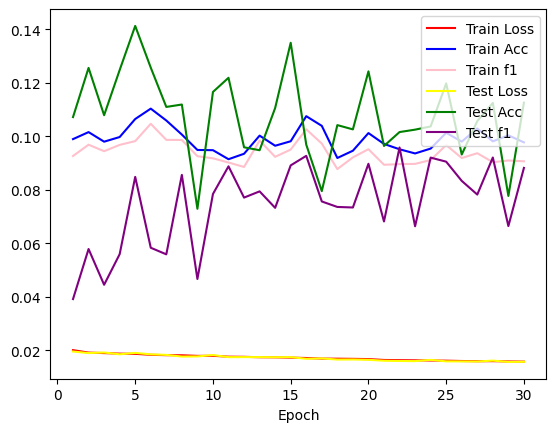

In [523]:
top_k_accuracy = np.mean(top_k_accuracies)
print(f"Top-{k} Accuracy: {top_k_accuracy}")

Epoch = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
plt.plot(Epoch, training_loss, c='red',label='Train Loss')
plt.plot(Epoch, training_acc, c='blue',label="Train Acc")
plt.plot(Epoch, training_f1, c='pink', label="Train f1")
#plt.plot(Epoch, training_recall, c='orange', label="Train recall")

plt.plot(Epoch, testing_loss, c='yellow', label="Test Loss")
plt.plot(Epoch, testing_acc, c='green', label="Test Acc")
plt.plot(Epoch, testing_f1, c='purple', label="Test f1")
#plt.plot(Epoch, testing_recall, c='black', label="Test recall")


plt.xlabel('Epoch')
plt.legend()
plt.show()

In [532]:
criterion =  nn.CrossEntropyLoss()

In [533]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

In [534]:
def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

In [535]:
from sklearn.metrics import f1_score, recall_score

training_loss = []
training_acc = []
training_f1 = []
training_recall = []

testing_loss = []
testing_acc = []
testing_f1 = []
testing_recall = []

k = 3
top_k_accuracies = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0
    
    epoch_true1 = []
    epoch_pred1 = []
    
    epoch_true2 = []
    epoch_pred2 = []
    
    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
       # print(outputs.size(),target.size())
        _, preds = torch.max(outputs, 1)

        #epoch_pred.append(preds.cpu())
        #print(preds.cpu().numpy())
        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)
        
        epoch_true1.extend(target.data.cpu().numpy())
        epoch_pred1.extend(preds.cpu().numpy())

        #epoch_true.append(target.data.cpu())
        #print(target.data.cpu().numpy())
        #print(f1_score(preds.cpu().numpy(), target.data.cpu().numpy(), average='weighted'))
        #F1_score.append(f1_score(preds.cpu().numpy(), target.data.cpu().numpy(),average='macro'))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    train_f1 = f1_score(epoch_true1, epoch_pred1, average="macro")
    train_recall = recall_score(epoch_true1, epoch_pred1, average="macro")
    
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    #print(f1)
    #print(recall)

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    training_f1.append(train_f1)
    training_recall.append(train_recall)
    

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            epoch_true2.extend(target.data.cpu().numpy())
            epoch_pred2.extend(preds.cpu().numpy())


            # 获取模型的预测结果
            with torch.no_grad():
                outputs = model(image)
    
        # 对每个样本计算Top-K准确度
            _, top_k_indices = torch.topk(outputs, k, dim=1)
            top_k_correct = [1 if true_label in top_k_indices[i] else 0 for i, true_label in enumerate(target)]
            top_k_accuracies.extend(top_k_correct)
            
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        
        test_f1 = f1_score(epoch_true2, epoch_pred2, average="macro")
        test_recall = recall_score(epoch_true2, epoch_pred2, average="macro") 
        
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
       #print(f1)
       #print(recall)
        
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
        testing_f1.append(test_f1)
        testing_recall.append(test_recall)

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0153 Acc: 0.2671
Begin test......
Test Loss: 0.0140 Acc: 0.3326
Epoch: 2/30 Train Loss: 0.0139 Acc: 0.3362
Begin test......
Test Loss: 0.0135 Acc: 0.3661
Epoch: 3/30 Train Loss: 0.0138 Acc: 0.3395
Begin test......
Test Loss: 0.0132 Acc: 0.3680
Epoch: 4/30 Train Loss: 0.0136 Acc: 0.3520
Begin test......
Test Loss: 0.0131 Acc: 0.3763
Epoch: 5/30 Train Loss: 0.0136 Acc: 0.3594
Begin test......
Test Loss: 0.0134 Acc: 0.3770
Epoch: 6/30 Train Loss: 0.0127 Acc: 0.4004
Begin test......
Test Loss: 0.0122 Acc: 0.4299
Epoch: 7/30 Train Loss: 0.0125 Acc: 0.4154
Begin test......
Test Loss: 0.0120 Acc: 0.4465
Epoch: 8/30 Train Loss: 0.0125 Acc: 0.4194
Begin test......
Test Loss: 0.0118 Acc: 0.4515
Epoch: 9/30 Train Loss: 0.0124 Acc: 0.4214
Begin test......
Test Loss: 0.0117 Acc: 0.4549
Epoch: 10/30 Train Loss: 0.0124 Acc: 0.4200
Begin test......
Test Loss: 0.0116 Acc: 0.4630
Epoch: 11/30 Train Loss: 0.0118 Acc: 0.4519
Begin test......
Test Loss: 0.0111 Acc: 0.4872
Epoch: 1

Top-3 Accuracy: 0.80736


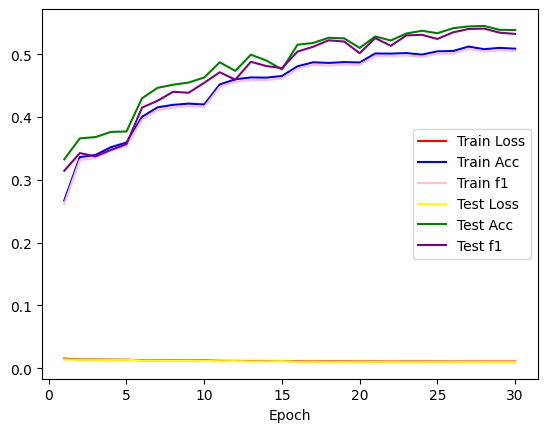

In [536]:
top_k_accuracy = np.mean(top_k_accuracies)
print(f"Top-{k} Accuracy: {top_k_accuracy}")

Epoch = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
plt.plot(Epoch, training_loss, c='red',label='Train Loss')
plt.plot(Epoch, training_acc, c='blue',label="Train Acc")
plt.plot(Epoch, training_f1, c='pink', label="Train f1")
#plt.plot(Epoch, training_recall, c='orange', label="Train recall")

plt.plot(Epoch, testing_loss, c='yellow', label="Test Loss")
plt.plot(Epoch, testing_acc, c='green', label="Test Acc")
plt.plot(Epoch, testing_f1, c='purple', label="Test f1")
#plt.plot(Epoch, testing_recall, c='black', label="Test recall")


plt.xlabel('Epoch')
plt.legend()
plt.show()

In [584]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0.5):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, input, target):
        # 计算交叉熵损失
        ce_loss = nn.functional.cross_entropy(input, target, reduction='none')
        
        # 计算权重
        p_t = torch.exp(-ce_loss)
        focal_weight = (1 - p_t) ** self.gamma
        
        # 计算 Focal Loss
        focal_loss = focal_weight * ce_loss
        
        # 返回平均损失
        return torch.mean(focal_loss)

In [585]:
criterion =  FocalLoss(gamma=0.5)

In [586]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

In [587]:
def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

In [588]:
from sklearn.metrics import f1_score, recall_score

training_loss = []
training_acc = []
training_f1 = []
training_recall = []

testing_loss = []
testing_acc = []
testing_f1 = []
testing_recall = []

k = 3
top_k_accuracies = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0
    
    epoch_true1 = []
    epoch_pred1 = []
    
    epoch_true2 = []
    epoch_pred2 = []
    
    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
       # print(outputs.size(),target.size())
        _, preds = torch.max(outputs, 1)

        #epoch_pred.append(preds.cpu())
        #print(preds.cpu().numpy())
        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)
        
        epoch_true1.extend(target.data.cpu().numpy())
        epoch_pred1.extend(preds.cpu().numpy())

        #epoch_true.append(target.data.cpu())
        #print(target.data.cpu().numpy())
        #print(f1_score(preds.cpu().numpy(), target.data.cpu().numpy(), average='weighted'))
        #F1_score.append(f1_score(preds.cpu().numpy(), target.data.cpu().numpy(),average='macro'))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    train_f1 = f1_score(epoch_true1, epoch_pred1, average="macro")
    train_recall = recall_score(epoch_true1, epoch_pred1, average="macro")
    
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    #print(f1)
    #print(recall)

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    training_f1.append(train_f1)
    training_recall.append(train_recall)
    

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            epoch_true2.extend(target.data.cpu().numpy())
            epoch_pred2.extend(preds.cpu().numpy())


            # 获取模型的预测结果
            with torch.no_grad():
                outputs = model(image)
    
        # 对每个样本计算Top-K准确度
            _, top_k_indices = torch.topk(outputs, k, dim=1)
            top_k_correct = [1 if true_label in top_k_indices[i] else 0 for i, true_label in enumerate(target)]
            top_k_accuracies.extend(top_k_correct)
            
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        
        test_f1 = f1_score(epoch_true2, epoch_pred2, average="macro")
        test_recall = recall_score(epoch_true2, epoch_pred2, average="macro") 
        
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
       #print(f1)
       #print(recall)
        
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
        testing_f1.append(test_f1)
        testing_recall.append(test_recall)

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0141 Acc: 0.2715
Begin test......
Test Loss: 0.0125 Acc: 0.3650
Epoch: 2/30 Train Loss: 0.0130 Acc: 0.3251
Begin test......
Test Loss: 0.0118 Acc: 0.3769
Epoch: 3/30 Train Loss: 0.0125 Acc: 0.3495
Begin test......
Test Loss: 0.0119 Acc: 0.3771
Epoch: 4/30 Train Loss: 0.0123 Acc: 0.3643
Begin test......
Test Loss: 0.0111 Acc: 0.4235
Epoch: 5/30 Train Loss: 0.0122 Acc: 0.3719
Begin test......
Test Loss: 0.0114 Acc: 0.4063
Epoch: 6/30 Train Loss: 0.0113 Acc: 0.4126
Begin test......
Test Loss: 0.0107 Acc: 0.4514
Epoch: 7/30 Train Loss: 0.0111 Acc: 0.4244
Begin test......
Test Loss: 0.0103 Acc: 0.4649
Epoch: 8/30 Train Loss: 0.0110 Acc: 0.4319
Begin test......
Test Loss: 0.0102 Acc: 0.4730
Epoch: 9/30 Train Loss: 0.0108 Acc: 0.4431
Begin test......
Test Loss: 0.0108 Acc: 0.4619
Epoch: 10/30 Train Loss: 0.0109 Acc: 0.4374
Begin test......
Test Loss: 0.0103 Acc: 0.4710
Epoch: 11/30 Train Loss: 0.0103 Acc: 0.4650
Begin test......
Test Loss: 0.0094 Acc: 0.5174
Epoch: 1

Top-3 Accuracy: 0.8141566666666666


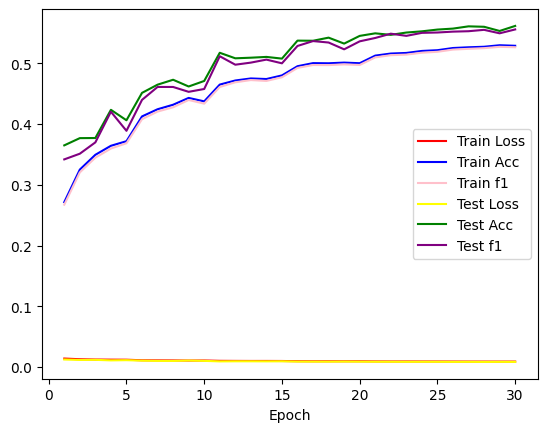

In [589]:
top_k_accuracy = np.mean(top_k_accuracies)
print(f"Top-{k} Accuracy: {top_k_accuracy}")

Epoch = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
plt.plot(Epoch, training_loss, c='red',label='Train Loss')
plt.plot(Epoch, training_acc, c='blue',label="Train Acc")
plt.plot(Epoch, training_f1, c='pink', label="Train f1")
#plt.plot(Epoch, training_recall, c='orange', label="Train recall")

plt.plot(Epoch, testing_loss, c='yellow', label="Test Loss")
plt.plot(Epoch, testing_acc, c='green', label="Test Acc")
plt.plot(Epoch, testing_f1, c='purple', label="Test f1")
#plt.plot(Epoch, testing_recall, c='black', label="Test recall")


plt.xlabel('Epoch')
plt.legend()
plt.show()

In [571]:
criterion =  FocalLoss(gamma=2)

In [572]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

In [573]:
def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

In [574]:
from sklearn.metrics import f1_score, recall_score

training_loss = []
training_acc = []
training_f1 = []
training_recall = []

testing_loss = []
testing_acc = []
testing_f1 = []
testing_recall = []

k = 3
top_k_accuracies = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0
    
    epoch_true1 = []
    epoch_pred1 = []
    
    epoch_true2 = []
    epoch_pred2 = []
    
    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
       # print(outputs.size(),target.size())
        _, preds = torch.max(outputs, 1)

        #epoch_pred.append(preds.cpu())
        #print(preds.cpu().numpy())
        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)
        
        epoch_true1.extend(target.data.cpu().numpy())
        epoch_pred1.extend(preds.cpu().numpy())

        #epoch_true.append(target.data.cpu())
        #print(target.data.cpu().numpy())
        #print(f1_score(preds.cpu().numpy(), target.data.cpu().numpy(), average='weighted'))
        #F1_score.append(f1_score(preds.cpu().numpy(), target.data.cpu().numpy(),average='macro'))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    train_f1 = f1_score(epoch_true1, epoch_pred1, average="macro")
    train_recall = recall_score(epoch_true1, epoch_pred1, average="macro")
    
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    #print(f1)
    #print(recall)

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    training_f1.append(train_f1)
    training_recall.append(train_recall)
    

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
            epoch_true2.extend(target.data.cpu().numpy())
            epoch_pred2.extend(preds.cpu().numpy())


            # 获取模型的预测结果
            with torch.no_grad():
                outputs = model(image)
    
        # 对每个样本计算Top-K准确度
            _, top_k_indices = torch.topk(outputs, k, dim=1)
            top_k_correct = [1 if true_label in top_k_indices[i] else 0 for i, true_label in enumerate(target)]
            top_k_accuracies.extend(top_k_correct)
            
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        
        test_f1 = f1_score(epoch_true2, epoch_pred2, average="macro")
        test_recall = recall_score(epoch_true2, epoch_pred2, average="macro") 
        
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
       #print(f1)
       #print(recall)
        
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())
        testing_f1.append(test_f1)
        testing_recall.append(test_recall)

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0115 Acc: 0.2560
Begin test......
Test Loss: 0.0102 Acc: 0.3269
Epoch: 2/30 Train Loss: 0.0103 Acc: 0.3129
Begin test......
Test Loss: 0.0095 Acc: 0.3589
Epoch: 3/30 Train Loss: 0.0102 Acc: 0.3152
Begin test......
Test Loss: 0.0096 Acc: 0.3453
Epoch: 4/30 Train Loss: 0.0102 Acc: 0.3176
Begin test......
Test Loss: 0.0093 Acc: 0.3465
Epoch: 5/30 Train Loss: 0.0101 Acc: 0.3188
Begin test......
Test Loss: 0.0094 Acc: 0.3501
Epoch: 6/30 Train Loss: 0.0093 Acc: 0.3600
Begin test......
Test Loss: 0.0086 Acc: 0.3815
Epoch: 7/30 Train Loss: 0.0091 Acc: 0.3679
Begin test......
Test Loss: 0.0084 Acc: 0.4198
Epoch: 8/30 Train Loss: 0.0090 Acc: 0.3783
Begin test......
Test Loss: 0.0091 Acc: 0.3809
Epoch: 9/30 Train Loss: 0.0089 Acc: 0.3866
Begin test......
Test Loss: 0.0083 Acc: 0.4147
Epoch: 10/30 Train Loss: 0.0088 Acc: 0.3883
Begin test......
Test Loss: 0.0085 Acc: 0.4042
Epoch: 11/30 Train Loss: 0.0084 Acc: 0.4192
Begin test......
Test Loss: 0.0076 Acc: 0.4649
Epoch: 1

Top-3 Accuracy: 0.7991766666666666


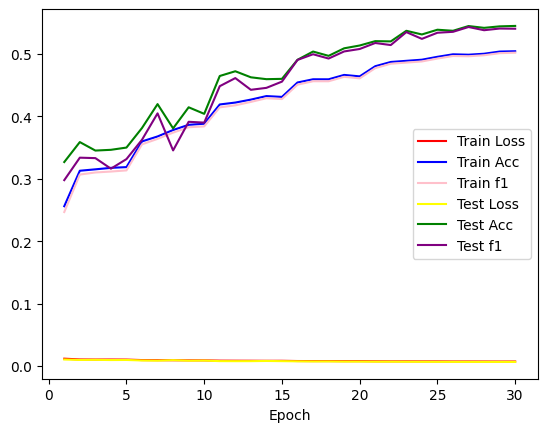

In [576]:
top_k_accuracy = np.mean(top_k_accuracies)
print(f"Top-{k} Accuracy: {top_k_accuracy}")

Epoch = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
plt.plot(Epoch, training_loss, c='red',label='Train Loss')
plt.plot(Epoch, training_acc, c='blue',label="Train Acc")
plt.plot(Epoch, training_f1, c='pink', label="Train f1")
#plt.plot(Epoch, training_recall, c='orange', label="Train recall")

plt.plot(Epoch, testing_loss, c='yellow', label="Test Loss")
plt.plot(Epoch, testing_acc, c='green', label="Test Acc")
plt.plot(Epoch, testing_f1, c='purple', label="Test f1")
#plt.plot(Epoch, testing_recall, c='black', label="Test recall")


plt.xlabel('Epoch')
plt.legend()
plt.show()

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [39]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [40]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
model.eval()
input = input.to(device)
logits = model(input.unsqueeze(0))
probabilities = F.softmax(logits, dim=1)
predict_label = torch.argmax(probabilities, dim=1)
probabilities = probabilities.squeeze()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


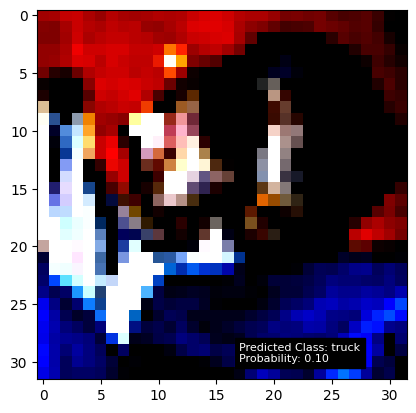

Print probabilities for each class:
airplane: 0.0992
automobile: 0.1007
bird: 0.1004
cat: 0.1002
deer: 0.0998
dog: 0.1007
frog: 0.0993
horse: 0.0992
ship: 0.0998
truck: 0.1008


In [41]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[predict_label].item()
input = input.cpu()
image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[i].item():.4f}')